In [1]:
import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [5]:
test_df

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler


In [6]:
train_df.date = pd.DatetimeIndex(train_df.date)
train_df['test'] = 0
test_df.date = pd.DatetimeIndex(test_df.date)
test_df['test'] = 1

In [8]:
class CFG:
    years_train = train_df.date.dt.year.unique()
    years_test = test_df.date.dt.year.unique()    
    years = np.concatenate((train_df.date.dt.year.unique(), test_df.date.dt.year.unique()))
    
    validation_year = 2000 # non-existing year or the year we use in validation - fill free to change this to 2016 or whatever you like
    
    countries = train_df.country.unique()
    stores = train_df.store.unique()
    products = train_df['product'].unique()

    alpha3 = {'Finland': 'FIN', 'Canada': 'CAN', 'Italy': 'IT', 'Kenya': 'KEN', 'Singapore': 'SGP', 'Norway': 'NOR'}

    fft_filter_width = 8

    countries_2l = {'Finland': 'FI', 'Canada': 'CA', 'Italy': 'IT', 'Kenya': 'KE', 'Singapore': 'SG', 'Norway': 'NO'}
    holiday_response_len = 10

In [10]:
years_train = train_df.date.dt.year.unique()
years_test = test_df.date.dt.year.unique()    
years = np.concatenate((train_df.date.dt.year.unique(), test_df.date.dt.year.unique()))
    
validation_year = 2000 # non-existing year or the year we use in validation - fill free to change this to 2016 or whatever you like
    
countries = train_df.country.unique()
stores = train_df.store.unique()
products = train_df['product'].unique()

alpha3 = {'Finland': 'FIN', 'Canada': 'CAN', 'Italy': 'IT', 'Kenya': 'KEN', 'Singapore': 'SGP', 'Norway': 'NOR'}

fft_filter_width = 8

countries_2l = {'Finland': 'FI', 'Canada': 'CA', 'Italy': 'IT', 'Kenya': 'KE', 'Singapore': 'SG', 'Norway': 'NO'}
holiday_response_len = 10

In [14]:
print(years_train,years_test,years)

[2010 2011 2012 2013 2014 2015 2016] [2017 2018 2019] [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


In [15]:
print(countries,stores,products)

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore'] ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart'] ['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


2. Decomposition¶
We start with defining many features, that could be helpful in the future work

In [16]:
df = pd.concat((train_df, test_df))
df.date = pd.DatetimeIndex(df.date)
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['dayofyear'] = df['date'].dt.dayofyear
df['daynum'] = (df.date - df.date.iloc[0]).dt.days
df['weeknum'] = df['daynum'] // 7
df['month'] = df.date.dt.month

In [17]:
df

,id,date,country,store,product,num_sold,test,year,weekday,dayofyear,daynum,weeknum,month
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,0,2010,4,1,0,0,1
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,0,2010,4,1,0,0,1
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,0,2010,4,1,0,0,1
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,0,2010,4,1,0,0,1
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0,2010,4,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,NaN,1,2019,1,365,3651,521,12
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,NaN,1,2019,1,365,3651,521,12
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,NaN,1,2019,1,365,3651,521,12
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,NaN,1,2019,1,365,3651,521,12


In [18]:
# Sinusoidal features
daysinyear = (df.groupby('year').id.count() / len(CFG.countries) / len(CFG.stores) / len(CFG.products)).rename('daysinyear').astype(int).to_frame()
df = df.join(daysinyear, on='year', how='left')
df['partofyear'] = (df['dayofyear'] - 1) / df['daysinyear']
df['partof2year'] = df['partofyear'] + df['year'] % 2
df['partof2year'] = df['partofyear'] + df['year'] % 2

In [19]:

CFG.sincoscol = [f'sin t', f'cos t', f'sin t/2', f'cos t/2']
CFG.sincoscol2 = [f'sin 2t', f'cos 2t', f'sin t', f'cos t', f'sin t/2', f'cos t/2']
df['sin 4t'] = np.sin(8 * np.pi * df['partofyear'])
df['cos 4t'] = np.cos(8 * np.pi * df['partofyear'])
df['sin 3t'] = np.sin(6 * np.pi * df['partofyear'])
df['cos 3t'] = np.cos(6 * np.pi * df['partofyear'])
df['sin 2t'] = np.sin(4 * np.pi * df['partofyear'])
df['cos 2t'] = np.cos(4 * np.pi * df['partofyear'])
df['sin t'] = np.sin(2 * np.pi * df['partofyear'])
df['cos t'] = np.cos(2 * np.pi * df['partofyear'])
df['sin t/2'] = np.sin(np.pi * df['partof2year'])
df['cos t/2'] = np.cos(np.pi * df['partof2year'])
df.drop(['daysinyear', 'partofyear', 'partof2year'], axis=1, inplace=True)

In [20]:
import requests
def get_gdp_per_capita(country,year):
    url="https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(CFG.alpha3[country],year)
    response = requests.get(url).json()
    return response[1][0]['value']

# gdp[counties x years]
gdp = np.array([[get_gdp_per_capita(country, year) for year in CFG.years] for country in CFG.countries])
gdp_df = pd.DataFrame(gdp, index=train_df.country.unique(), columns=CFG.years)

df['gdp_factor'] = None
for year in CFG.years:
    for country in CFG.countries:
        df.loc[(df.country == country) & (df.year == year), 'gdp_factor'] = gdp_df.loc[country, year]

2.2. Store factor¶
We exclude Canada and Kenya because of missed values

In [21]:
df_no_can_ken = df[~df.country.isin(('Canada', 'Kenya'))]

store_df = df_no_can_ken.groupby(by='store').num_sold.mean().rename('store_factor').to_frame()
df = df.drop('store_factor', axis=1, errors='ignore').join(store_df, on='store', how='left')

2.3. Product factor
We exclude Canada and Kenya because of missed values

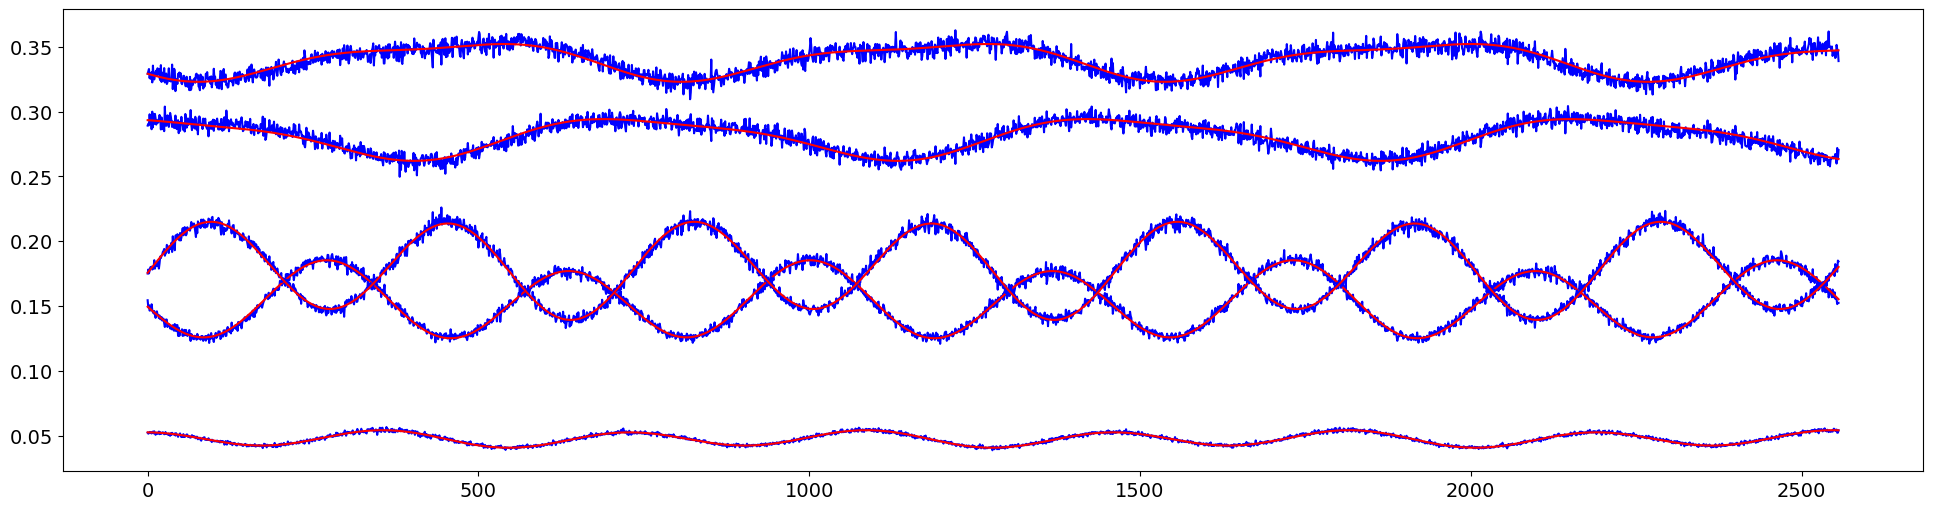

In [22]:
from sklearn.linear_model import Ridge

df_no_can_ken = df[~df.country.isin(('Canada', 'Kenya'))].copy()

total = df_no_can_ken.groupby(by='date').num_sold.sum().rename('num_sold_total')
df_no_can_ken = df_no_can_ken.join(total, on='date', how='left')
df_no_can_ken['num_sold_ratio'] = df_no_can_ken['num_sold'] / df_no_can_ken['num_sold_total']

plt.figure(figsize=(24, 6))
df['product_factor'] = None
for product in CFG.products:
    df_no_can_ken_date = df_no_can_ken[(df_no_can_ken['product'] == product) & (df_no_can_ken['test'] == 0)].groupby(by='date')
    x = df_no_can_ken_date[CFG.sincoscol].mean().to_numpy()
    y = df_no_can_ken_date.num_sold_ratio.sum().to_numpy()

    reg = Ridge()
    reg.fit(x, y)
    p = reg.predict(x)
    df.loc[(df['product'] == product), 'product_factor'] = reg.predict(df.loc[(df['product'] == product), CFG.sincoscol].to_numpy())
   
    plt.plot(y, 'b')
    plt.plot(p, 'r')
plt.show();